## EMG data processing

This tutorial is a part of IEEE Brain virtual summer school 2020. It contains basic Python codes for EMG data processing, and the Python codes for two simple computational tasks related to EMG. A brief introduction about how the data were collected can be found in the powerpoint file under the same folder.

Anaconda is highly recommended here. It can help you set up your own Python based scientific computation environment easily. You can install and begin to use Anaconda following [this link](https://docs.anaconda.com/anaconda/install/windows/).

We will heavily use Python packages including numpy, scipy, matplotlib, sklearn in this tutorial. Check [this link](https://docs.anaconda.com/ae-notebooks/4.3.1/user-guide/getting-started/?highlight=numpy#adding-scipy-and-numpy-packages) to find out how to add them into your environment if you are new in Python. 

When your environment is set, use `git` to clone this repo or simply download it to your local machine. Use jupyter notebook to open this file. Tips on how to use jupyter notebook can be found [here](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html).

There are some functions wrapped in `EMG_processing_lib.py` under the same folder. Check that file and find out how you could use it or modify it for your own analyses. 

All data were collected in Miller Limb Lab, Northwestern University. Data are available only for learning purpose. Send an email to xuan.ma1@northwestern.edu if you want to play with the data by yourself.

### 1. Loading data from .mat files

For flexibly using across platforms, the data are stored in MATLAB format (.mat). Such files can be read with certain functions in scipy, as shown below. 

Data are stored in a dictionary structure (`data`) after being loaded.

&emsp;`data['raw_EMG']`: EMG data from 4 muscles sampling with 2 kHz

&emsp;`data['force']`: force data for Fx and Fy, sampling with 1 kHz

&emsp;`data['EMG_names']`: the name for each muscle being recorded

&emsp;`data['trial_start']`, `data['trial_end']`, `data['trial_gocue']`: the timings of the behevior events during the experiment. 

&emsp;`data['target_dir']`: the direction of the target 

&emsp;`data['trial_result']`: to tell whether the monkey got reward during one trial. 'R' means 'rewarded'. 'F' means 'failed'. Almost all 'R' here.

&emsp;`fs`: sampling frequency for EMG data

&emsp;`fs_force`: sampling frequency for force data

In [1]:
%matplotlib inline
import scipy.io as sio
path = './'
file_name = 'EMG_force_sample1.mat'
data = sio.loadmat(path + file_name)
fs = data['fs'][0][0]
fs_force = data['fs_force'][0][0]
EMG_names = []
for i in range(data['raw_EMG'].shape[1]):
    EMG_names.append(data['EMG_names'][0][i][0])
print('There are %d samples for EMGs from %d channels' % (data['raw_EMG'].shape[0], data['raw_EMG'].shape[1]))
print('Since the sampling frequency for EMG is %f Hz, the length for the recording is %.3f seconds' 
      % (fs, data['raw_EMG'].shape[0]/fs))
print('There are %d samples for %d-ch forces' % (data['force'].shape[0], data['force'].shape[1]))
print('The sampling frequency for the force data is %d Hz' % (fs_force))

There are 2399413 samples for EMGs from 4 channels
Since the sampling frequency for EMG is 2000.000000 Hz, the length for the recording is 1199.707 seconds
There are 1199707 samples for 2-ch forces
The sampling frequency for the force data is 1000 Hz


### 2. Plotting data samples

The plotting will call several functions in `EMG_processing_lib.py` under the same folder. 

A figure showing EMG samples from the beginning of the 115th trial to the beginning of the 121st trial


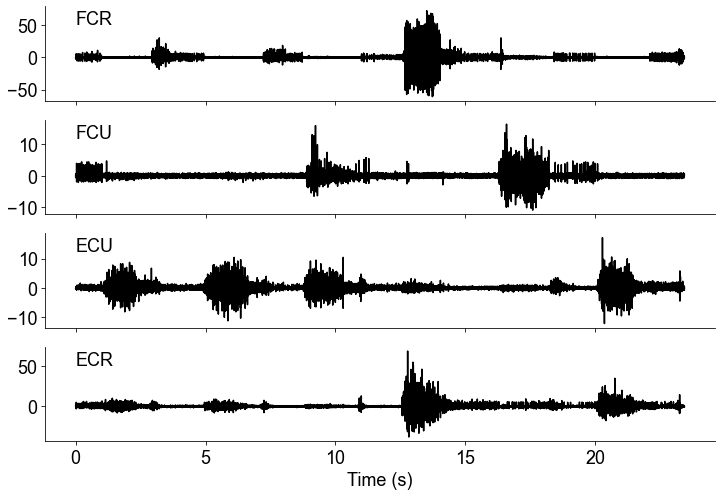

A figure showing force samples from the beginning of the 115th trial to the beginning of the 121st trial


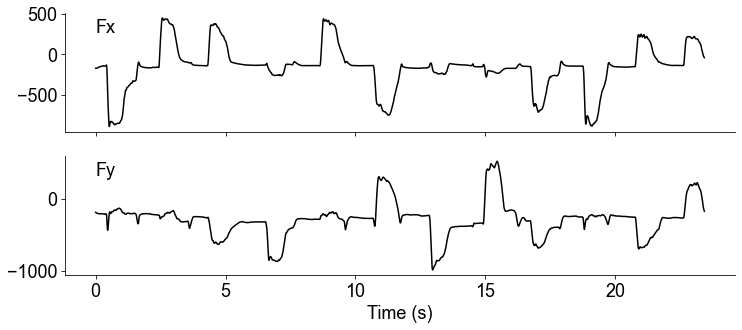

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from EMG_processing_lib import plot_EMG
from matplotlib import rcParams

rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

print('A figure showing EMG samples from the beginning of the 115th trial to the beginning of the 121st trial')
fig = plt.figure('Raw EMGs', figsize=(12, 8))
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_EMG(data['raw_EMG'], EMG_names, fs, t_start, t_end )
plt.show()

print('A figure showing force samples from the beginning of the 115th trial to the beginning of the 121st trial')
fig = plt.figure('Force', figsize = (12, 5))
plt.subplots_adjust(bottom = 0.15)
plot_EMG(data['force'], ['Fx', 'Fy'], fs, t_start, t_end )
plt.show()

### 3. Data in frequency domain

Two basic tasks are performed here to show the properties of the EMGs in frequency domain.
1. Estimating power spectral density using Welch’s method with a very long data segment.
2. Computing a spectrogram for each EMG channel with consecutive Fourier transforms.

Results from the first analysis can demostrate the overall intensity of each frequency component, while the second analysis can be used as a way of visualizing the change of a nonstationary signal’s frequency content over time.

`scipy.signal` provides a function `welch` to compute the power spectral of a signal. The documentation of this function can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). This function is called by `plot_EMG_spectral()` in `EMG_processing_lib.py`.

A figure showing the power spectral for each EMG channel.


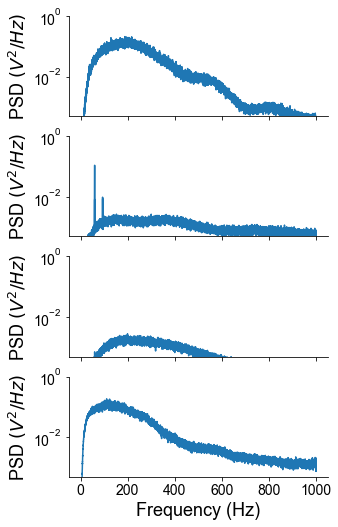

In [3]:
from EMG_processing_lib import plot_EMG_spectral
fig = plt.figure('power spectral', figsize=(6, 8))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_EMG_spectral(data['raw_EMG'], EMG_names, fs, t_start, t_end )
print('A figure showing the power spectral for each EMG channel.')

`scipy.signal` also provides [`spectrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) to compute the spectrogram of a signal. It is called by `plot_EMG_spectrogram()` in `EMG_processing_lib.py`. In this demo `nperseg = 256`, `noverlap = 64`, `nfft = 256`, leading to a frequency resolution of 7.8 Hz and a temporal resolution of 10 msec.

A figure showing the spectrogram of each EMG channel


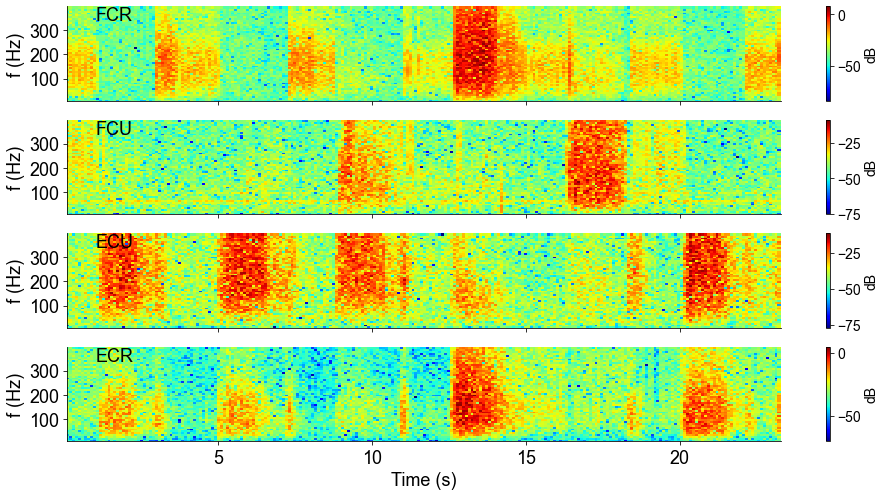

In [4]:
from EMG_processing_lib import plot_EMG_spectrogram
print('A figure showing the spectrogram of each EMG channel')
fig = plt.figure('spectrogram', figsize=(16, 8))
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_EMG_spectrogram(data['raw_EMG'], EMG_names, fs, t_start, t_end )

### 4. Signal filtering to extract EMG envelops

In general, we are interested in the envelops of EMGs, for they are informative with the timing and intensity of muscle contractions, and are capable for many computational tasks.

Here we use [scipy.signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) to design digital filters for signal filtering. This function is MATLAB style and very easy to use, no need for considering zeros and poles. You only need to specify the order of the filter with the first parameter, the corner frequency with the second parameter and the type of the filter with the third parameter. 

The function `plot_filter_amp_response()` calls [scipy.signal.freqz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) to plot the frequency responses of different filters.

A figure showing the frequency response of a high-pass filter


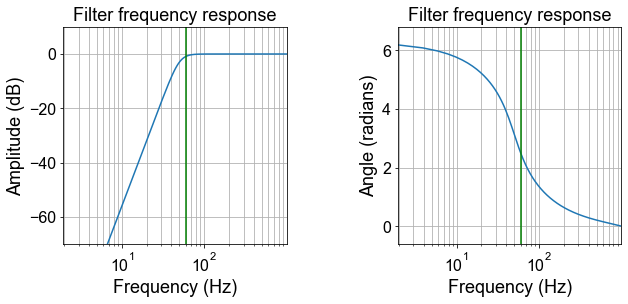

In [5]:
import scipy.signal as signal
from EMG_processing_lib import plot_filter_amp_response
bhigh, ahigh = signal.butter(4, 50/(fs/2), 'high')
print('A figure showing the frequency response of a high-pass filter')
fig = plt.figure('HP filter', figsize=(10, 4))
plt.subplots_adjust(wspace = 0.5, hspace = 0.1)
plot_filter_amp_response(bhigh, ahigh, fs, 60)

A figure showing the frequency response of a low-pass filter


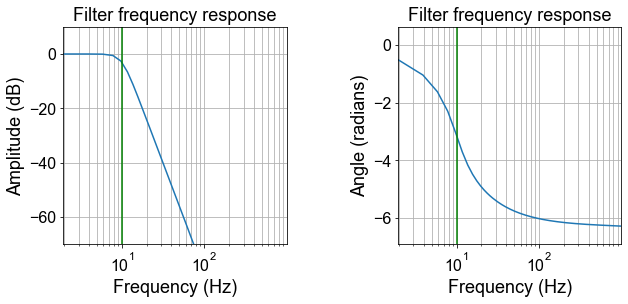

In [6]:
blow, alow = signal.butter(4, 10/(fs/2), 'low')
print('A figure showing the frequency response of a low-pass filter')
fig = plt.figure('LP filter', figsize=(10, 4))
plt.subplots_adjust(wspace = 0.5, hspace = 0.1)
plot_filter_amp_response(blow, alow, fs, 10)

[`scipy.signal.filtfilt`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) applies a digital filter forward and backward to a signal. For online data processing you cannot do this. But for offline analyses this type of acausal filtering works well.

In [7]:
filtered_EMG1, rtf_EMG1, filtered_EMG2 = [], [], []
for i in range(4):
    filtered_EMG1.append(signal.filtfilt(bhigh, ahigh, data['raw_EMG'][:, i]))
for i in range(4):
    rtf_EMG1.append(np.abs(filtered_EMG1[i]))
for i in range(4):
    filtered_EMG2.append(signal.filtfilt(blow, alow, rtf_EMG1[i]))
filtered_EMG1, rtf_EMG1, filtered_EMG2 = np.asarray(filtered_EMG1).T, np.asarray(rtf_EMG1).T, np.asarray(filtered_EMG2).T

Plotting the filtered or rectified signals.

A figure showing the EMGs after high-pass filtering


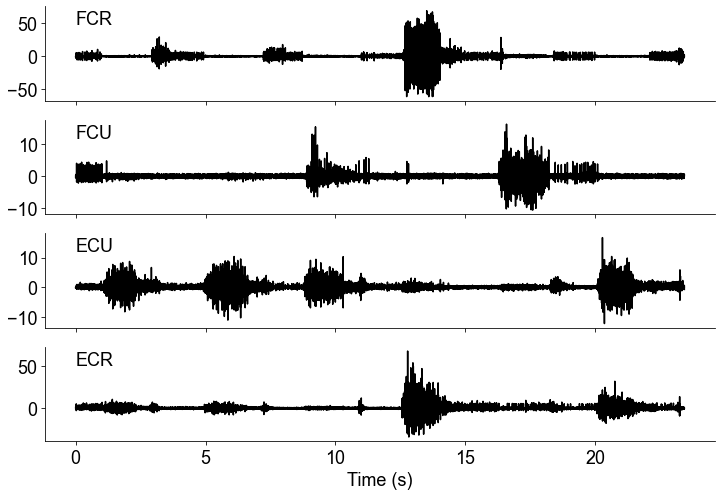

A figure showing the EMGs after full-wave rectifying


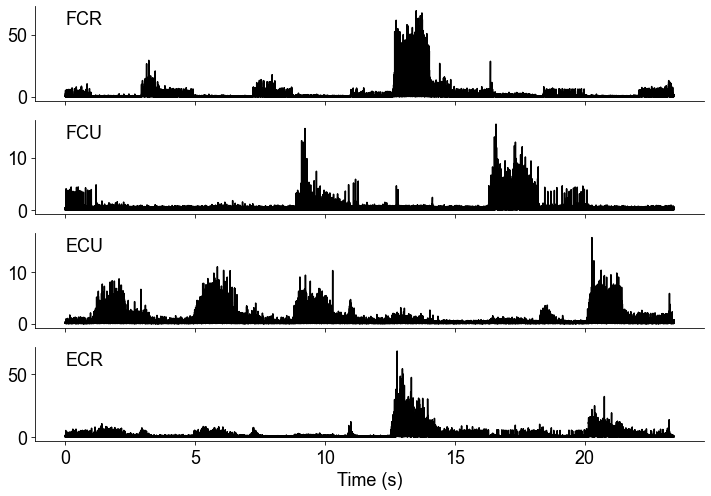

A figure showing the EMGs after low-pass filtering


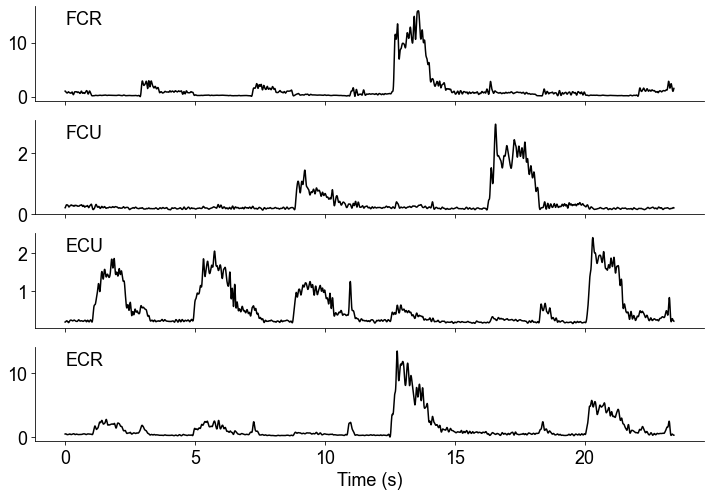

In [8]:
print('A figure showing the EMGs after high-pass filtering')
fig = plt.figure('HP filtered EMGs', figsize=(12, 8))
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_EMG(filtered_EMG1, EMG_names, fs, t_start, t_end )
plt.show()

print('A figure showing the EMGs after full-wave rectifying')
fig = plt.figure('Rectified EMGs', figsize=(12, 8))
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_EMG(rtf_EMG1, EMG_names, fs, t_start, t_end )
plt.show()

print('A figure showing the EMGs after low-pass filtering')
fig = plt.figure('LP filtered EMGs', figsize=(12, 8))
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_EMG(filtered_EMG2, EMG_names, fs, t_start, t_end )
plt.show()

### 5. EMG down-sampling

`scipy.signal.decimate` will apply anti-aliasing filter before down-sampling. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html to find more.
When using IIR downsampling, it is recommended to call decimate multiple times for downsampling factors higher than 13.

Here we want to down-sample the EMGs to `fs_ds = 20` Hz. The dwonsampling factor is 100 (namely `2000 / 20`). So the `decimate` function is called twice.

Notice that the downsampling factor for force data is 50 (namely `1000 / 20`).

A figure showing the EMG envelops after down-sampling


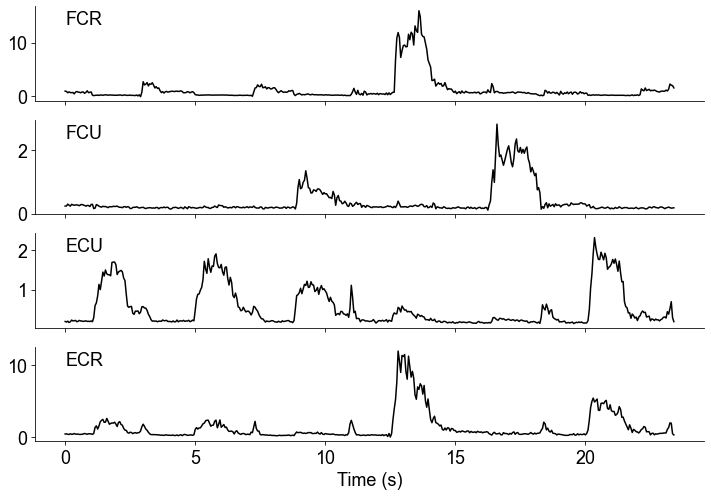

In [9]:
fs_ds = 20
ds_EMG, ds_force = [], []
for i in range(4):
    temp = signal.decimate(filtered_EMG2[:, i], 10)
    ds_EMG.append(signal.decimate(temp, 10))
for i in range(2):
    temp = signal.decimate(data['force'][:, i], 10)
    ds_force.append(signal.decimate(temp, 5))
    
ds_EMG, ds_force = np.asarray(ds_EMG).T, np.asarray(ds_force).T
time_frame = np.arange(ds_EMG.shape[0])/fs_ds

print('A figure showing the EMG envelops after down-sampling')
fig = plt.figure('DS filtered EMGs', figsize=(12, 8))
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_EMG(ds_EMG, EMG_names, fs/100, t_start, t_end )

`ds_EMG` stores the downsampled EMG envelops, and will be used in the following data analyses.

`ds_force` stores the downsampled force data.

### 6. Computational task 1: Estimating wrist movement directions from EMGs

Can we estimate which direction the monkey was moving the cursor to with EMGs inside a specific short window? This task tries to solve this problem by building a classifier to discriminate different EMG patterns.

First, the position of the time window needs to be specified by t1 and t2. The directions of targets listed in `target_ist` are treated as class labels.

In [10]:
t1, t2 = 0, 0.5 # t1 is the time before Go_cue time, t2 is the time after Go_cue time
trial_len = int((t1 + t2)*fs_ds)
target_list = [-135, -90, -45, 0, 45, 90, 135, 180]
color_list = ['orange', 'cyan', 'brown', 'magenta', 'blue', 'green', 'purple', 'greenyellow']
print('%d samples in each trial are used to build the classifier'%(trial_len))

10 samples in each trial are used to build the classifier


Here we extract trials based on the timing of the event 'trial_gocue', and store the results in a list named as `trial_EMG`. Since there are 294 trials in this demo, the length of `trial_EMG` is 294. Each entry in `trial_EMG` is a `10*4` array, with rows as samples and columns as variables (muscles). 

In [11]:
trial_EMG, trial_force = [], []
for each in data['trial_gocue']:
    idx = np.where((time_frame > each - t1)&(time_frame < each + t2))[0]
    trial_EMG.append(ds_EMG[idx, :])
    #trial_force.append(ds_force[idx, :])

To be used for further analyses, here we reshape each entry in `trial_EMG` into a vector. Since this vector contains both spatial and temporal information for muscle activation in each trial, it can be called as 'a spatial-temporal vector'. After reshaping, we get another list called `trial_EMG_vector`. Each entry in this list contains a vector with 40 dimensions. At the end of this cell, we transform the list into an array.

In [12]:
trial_EMG_vector = []
for each in trial_EMG:
    trial_EMG_vector.append(np.asarray(each).reshape(trial_len*4, ))
trial_EMG_vector = np.asarray(trial_EMG_vector)

Here we use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to do dimensionality reduction on `trial_EMG_vector`. The dimensions are reduced from 40 to 8 after applying PCA. Then the first 2 components are plotted one against each other to visulize the patterns of data.

[0.61853023 0.22213934 0.0886179  0.02485082 0.00880791 0.00753217
 0.00557166 0.00476472]


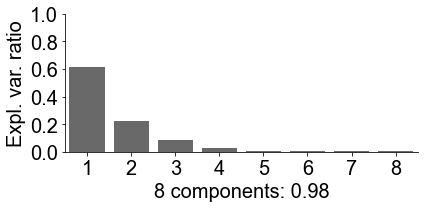

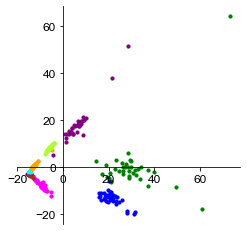

In [13]:
from EMG_processing_lib import plot_pca_var_ratio, plot_scatters
from sklearn.decomposition import PCA
pca = PCA(n_components = 8)
pca.fit(trial_EMG_vector)
print(pca.explained_variance_ratio_)

fig = plt.figure('PCA explained', figsize=(6, 3))
plot_pca_var_ratio(pca)

trial_EMG_vector_pca = pca.transform(trial_EMG_vector)

fig = plt.figure('EMG scatter pca', figsize=(4, 4))
plot_scatters(trial_EMG_vector_pca, data['target_dir'], target_list, color_list)

Another great tool for data visulization is [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE). This cell demonstate how to use t-SNE for data visulization. t-SNE is pretty stochastic, so you can get different plots after each run. Be aware that the most useful function of t-SNE is visulization.

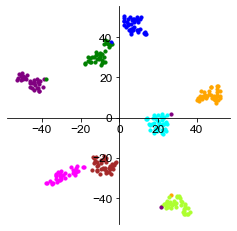

In [14]:
from sklearn.manifold import TSNE
trial_EMG_vector_tsne = TSNE(n_components = 2, perplexity = 10, learning_rate = 400,
                             early_exaggeration = 20).fit_transform(trial_EMG_vector)
fig = plt.figure('EMG scatter tsne', figsize=(4, 4))
plot_scatters(trial_EMG_vector_tsne, data['target_dir'], target_list, color_list)

Now we can build the aforementioned classifier. First, dealing with the class labels.

In [15]:
y = []
for i in range(len(trial_EMG)):
    y.append(np.where(target_list == data['target_dir'][i][0])[0][0])
y = np.asarray(y).reshape((-1, ))

Function [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) is used to spilit training and testing sets. In this demo we train on 50% data and test on another 50%.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
for train_index, test_index in split.split(trial_EMG_vector, y):
    X_train, X_test = trial_EMG_vector[train_index], trial_EMG_vector[test_index]
    y_train, y_test = y[train_index], y[test_index]

Multi-layer perceptron (MLP) is a typical classifier for discriminating data patterns. In `sklearn` it is implemented by [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). For simplicity we directly call this function here, but it will be helpful if you could build your own from scratch.

In [17]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter = 600).fit(X_train, y_train)
y_pred = clf.predict(X_test)

We can plot a confusion matrix to check how well the classifier can do.

The overall classifying accuracy is 0.973


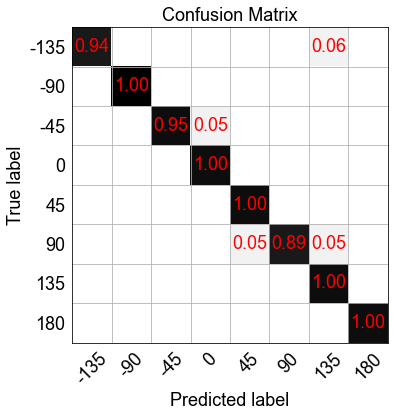

In [18]:
from sklearn.metrics import confusion_matrix
from EMG_processing_lib import plot_confusion_matrix

print('The overall classifying accuracy is %.3f' %(clf.score(X_test, y_test)))
cm = confusion_matrix(y_test, y_pred)
plt.figure('confusion matrix', figsize=(8, 6))
plot_confusion_matrix(cm, target_list)

### 7. Computational task 2: Predicting forces from EMGs

First, import useful functions from `winer_filter.py` under the same folder. And also import `r2_score` from sklearn.metrics for performance evaluation

In [19]:
from wiener_filter import format_data, train_wiener_filter, test_wiener_filter
from sklearn.metrics import r2_score
from EMG_processing_lib import plot_predictions

The function `format_data` will add history (5 lags) for each sample to form the right training and testing set. Data collected during the first 10 minutes are used for training. Data collected afterwards are used for testing.

In [20]:
X_train, y_train = ds_EMG[:ds_EMG.shape[0]//2, :], ds_force[:ds_EMG.shape[0]//2, :]
X_test, y_test = ds_EMG[ds_EMG.shape[0]//2:, :], ds_force[ds_EMG.shape[0]//2:, :]
print('The size of input data for training before data formatting is (%d, %d)'% X_train.shape)
print('The size of output data for training before data formatting is (%d, %d)'% y_train.shape)
lags = 5
X_train, y_train = format_data(X_train, y_train, lags)
X_test, y_test = format_data(X_test, y_test, lags)
print('\nAs we add 5 lags as the history:')
print('The size of input data for training after data formatting is (%d, %d)'% X_train.shape)
print('The size of output data for training after data formatting is (%d, %d)'% y_train.shape)

The size of input data for training before data formatting is (11997, 4)
The size of output data for training before data formatting is (11997, 2)

As we add 5 lags as the history:
The size of input data for training after data formatting is (11992, 20)
The size of output data for training after data formatting is (11992, 2)


Now call train_wiener_filter to fit a decoder with X_train and y_train as the training data:

In [21]:
H_reg = train_wiener_filter(X_train, y_train)
print('The shape of the filter matrix H_reg is (%d, %d)'%(H_reg.shape))

The shape of the filter matrix H_reg is (21, 2)


With the filter matrix obtained from training, we can try to predict forces with EMG envelops on the held-out testing data

The prediction accuracy (R^2) for Fy on testing set is 0.803
The prediction accuracy (R^2) for Fy on testing set is 0.928


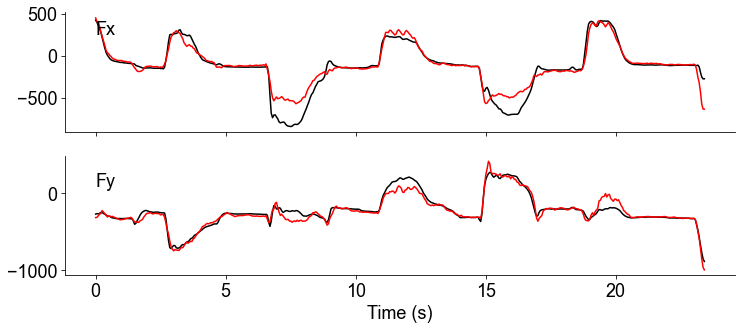

In [22]:
y_test_pred = test_wiener_filter(X_test, H_reg)
r2 = r2_score(y_test, y_test_pred, multioutput = 'raw_values')
print('The prediction accuracy (R^2) for Fy on testing set is %.3f'%(r2[0]))
print('The prediction accuracy (R^2) for Fy on testing set is %.3f'%(r2[1]))
fig = plt.figure('Predicted Forces', figsize=(12, 5))
plt.subplots_adjust(bottom=0.15)
t_start, t_end = data['trial_start'][115], data['trial_start'][121]
plot_predictions(y_test, y_test_pred, ['Fx', 'Fy'], fs_ds, t_start, t_end )